### Demo for local autoencoder creation & training
* steps on how table data can be slowly broken down and later fed to an autoencoder model
* Steps learned can be applied to BigQuery autoencoder

In [1]:
!pip install phonenumbers #https://pypi.org/project/phonenumbers/

In [4]:
# Import libraries that will be needed for the lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import os, datetime
import glob
import pickle
import random

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_curve, auc, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

2024-09-12 14:26:15.053166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 14:26:15.053304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 14:26:15.239320: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 14:26:15.765563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#MOUNTED_BUCKET="avoxi_workshop_bucket"
DATA_DIR="data/input/data_initial_data_cdr-data-000000000000"

In [1]:
!ls data/input

data_initial_data_cdr-data-000000000000


In [5]:
# Specify the path to your CSV file
import os
import pandas as pd

# Define the directory path
#csv_file_path = os.path.expanduser(f'~/{MOUNTED_BUCKET}/{DATA_DIR}')  # Adjust the relative path from the notebook to the csv folder
csv_file_path = os.path.expanduser(f'{DATA_DIR}')

tmp_list = []
for csv_file in glob.glob(csv_file_path):
    # Read the CSV file into a DataFrame
    tmp_series = pd.read_csv(csv_file, delimiter=',', parse_dates=True)
    tmp_list.append(tmp_series)

df = pd.concat(tmp_list)

# Display the first few rows of the DataFrame
df

,caller_id,organization_id,e164_from_caller_id,e164_to_caller_id,status,start_time,duration,data_center,carrier_id,packet_loss,mos,jitter,label,origination,destination
0,3a2d8e80-21f1-11ed-837d-42010a4d3f9c,cdab08cb-21ee-11ed-a07b-7e6bef5c3968,1.678001e+10,7.003430e+06,answered,2022-08-22 08:05:46 UTC,2,NaN,NaN,0.0,0.0,0,NaN,US,NaN
1,63e2170c-11f5-11ed-996d-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,5.244200e+11,8.000000e+08,unanswered,2022-08-01 23:55:15 UTC,1,NaN,NaN,0.0,0.0,0,unanswered_no_outbound_routing,NaN,001
2,024af168-18d4-11ed-ae9d-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,5.244200e+11,8.000000e+08,unanswered,2022-08-10 17:43:57 UTC,0,NaN,NaN,0.0,0.0,0,unanswered_no_outbound_routing,NaN,001
3,4c4eb2e8-18f4-11ed-badb-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,5.244200e+11,8.000000e+08,answered,2022-08-10 21:35:05 UTC,252,NaN,NaN,0.0,4.3,103,NaN,NaN,001
4,2be44a04-2240-11ed-8737-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,5.244200e+11,8.000000e+08,answered,2022-08-22 17:30:52 UTC,334,NaN,NaN,0.0,4.4,90,NaN,NaN,001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304532,00ae7d5c-1e42-11ed-b685-42010a4d3f9c,dd93f033-f46c-11ea-bdd2-621a0d00b163,5.400000e+11,5.411000e+11,answered,2022-08-17 15:33:54 UTC,469,NaN,186.0,0.0,1.1,393,NaN,AR,AR
304533,8ad5dd74-1e95-11ed-a997-42010a4d3f9c,dd93f033-f46c-11ea-bdd2-621a0d00b163,5.400000e+11,5.411000e+11,answered,2022-08-18 01:31:54 UTC,166,NaN,186.0,0.0,2.0,198,NaN,AR,AR
304534,f04576a8-135d-11ed-a317-42010a4d3f9b,dd93f033-f46c-11ea-bdd2-621a0d00b163,5.400000e+11,5.411000e+11,answered,2022-08-03 18:56:10 UTC,54,NaN,186.0,0.0,1.9,273,NaN,AR,AR
304535,36de9d32-2331-11ed-ac48-42010a4d3f9b,dd93f033-f46c-11ea-bdd2-621a0d00b163,5.400000e+11,5.411000e+11,answered,2022-08-23 22:16:20 UTC,756,NaN,186.0,0.0,1.2,400,NaN,AR,AR


In [8]:
df.describe()

,e164_from_caller_id,e164_to_caller_id,duration,carrier_id,packet_loss,mos,jitter
count,3.013700e+05,3.045300e+05,304537.000000,277251.000000,304537.000000,304537.000000,304537.000000
mean,6.779917e+11,4.029615e+12,334.164854,67.337813,0.020536,3.715556,39.900107
std,4.320279e+13,8.029728e+13,469.962691,40.250320,0.780133,1.588194,96.774526
min,5.377000e+03,7.003430e+06,0.000000,1.000000,0.000000,0.000000,0.000000
25%,4.179000e+10,1.877000e+10,43.000000,29.000000,0.000000,4.200000,1.000000
50%,2.557130e+11,5.280000e+11,188.000000,63.000000,0.000000,4.500000,4.000000
75%,5.296200e+11,9.100000e+11,458.000000,99.000000,0.000000,4.500000,37.000000
max,2.000000e+16,6.600000e+15,14412.000000,186.000000,96.679000,4.500000,3358.000000


In [9]:
df.dtypes

caller_id               object
organization_id         object
e164_from_caller_id    float64
e164_to_caller_id      float64
status                  object
start_time              object
duration                 int64
data_center             object
carrier_id             float64
packet_loss            float64
mos                    float64
jitter                   int64
label                   object
origination             object
destination             object
dtype: object

In [10]:
df = df.drop(columns=['status'])

In [11]:
df

,caller_id,organization_id,e164_from_caller_id,e164_to_caller_id,start_time,duration,data_center,carrier_id,packet_loss,mos,jitter,label,origination,destination
0,3a2d8e80-21f1-11ed-837d-42010a4d3f9c,cdab08cb-21ee-11ed-a07b-7e6bef5c3968,1.678001e+10,7.003430e+06,2022-08-22 08:05:46 UTC,2,NaN,NaN,0.0,0.0,0,NaN,US,NaN
1,63e2170c-11f5-11ed-996d-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,5.244200e+11,8.000000e+08,2022-08-01 23:55:15 UTC,1,NaN,NaN,0.0,0.0,0,unanswered_no_outbound_routing,NaN,001
2,024af168-18d4-11ed-ae9d-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,5.244200e+11,8.000000e+08,2022-08-10 17:43:57 UTC,0,NaN,NaN,0.0,0.0,0,unanswered_no_outbound_routing,NaN,001
3,4c4eb2e8-18f4-11ed-badb-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,5.244200e+11,8.000000e+08,2022-08-10 21:35:05 UTC,252,NaN,NaN,0.0,4.3,103,NaN,NaN,001
4,2be44a04-2240-11ed-8737-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,5.244200e+11,8.000000e+08,2022-08-22 17:30:52 UTC,334,NaN,NaN,0.0,4.4,90,NaN,NaN,001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304532,00ae7d5c-1e42-11ed-b685-42010a4d3f9c,dd93f033-f46c-11ea-bdd2-621a0d00b163,5.400000e+11,5.411000e+11,2022-08-17 15:33:54 UTC,469,NaN,186.0,0.0,1.1,393,NaN,AR,AR
304533,8ad5dd74-1e95-11ed-a997-42010a4d3f9c,dd93f033-f46c-11ea-bdd2-621a0d00b163,5.400000e+11,5.411000e+11,2022-08-18 01:31:54 UTC,166,NaN,186.0,0.0,2.0,198,NaN,AR,AR
304534,f04576a8-135d-11ed-a317-42010a4d3f9b,dd93f033-f46c-11ea-bdd2-621a0d00b163,5.400000e+11,5.411000e+11,2022-08-03 18:56:10 UTC,54,NaN,186.0,0.0,1.9,273,NaN,AR,AR
304535,36de9d32-2331-11ed-ac48-42010a4d3f9b,dd93f033-f46c-11ea-bdd2-621a0d00b163,5.400000e+11,5.411000e+11,2022-08-23 22:16:20 UTC,756,NaN,186.0,0.0,1.2,400,NaN,AR,AR


In [13]:
# Convert the `164_from_caller_id`, `164_to_caller_id` & `carrier_id` columns to 'Object' datatype
df['e164_from_caller_id'] = df['e164_from_caller_id'].astype(str)
df['e164_to_caller_id'] = df['e164_to_caller_id'].astype(str)
df['carrier_id'] = df['carrier_id'].astype(str)

# Identify non-numeric columns
non_numeric_cols = np.concatenate([df.select_dtypes(exclude=[np.number]).columns])
numeric_cols = [col for col in df.select_dtypes(include=np.number)]

print(f"Numeric columns: {numeric_cols}")
print(f"Non-numeric columns: {non_numeric_cols}")

Numeric columns: ['duration', 'packet_loss', 'mos', 'jitter']
Non-numeric columns: ['caller_id' 'organization_id' 'e164_from_caller_id' 'e164_to_caller_id'
 'start_time' 'data_center' 'carrier_id' 'label' 'origination'
 'destination']


In [14]:
# column names
# data types
# dataset memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304537 entries, 0 to 304536
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   caller_id            304537 non-null  object 
 1   organization_id      304537 non-null  object 
 2   e164_from_caller_id  304537 non-null  object 
 3   e164_to_caller_id    304537 non-null  object 
 4   start_time           304537 non-null  object 
 5   duration             304537 non-null  int64  
 6   data_center          9313 non-null    object 
 7   carrier_id           304537 non-null  object 
 8   packet_loss          304537 non-null  float64
 9   mos                  304537 non-null  float64
 10  jitter               304537 non-null  int64  
 11  label                27475 non-null   object 
 12  origination          259550 non-null  object 
 13  destination          304515 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 32.5+ MB


In [15]:
# Check for missing values in the dataframe and display the result
print("\nMissing Values:\n")
print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))


Missing Values:

|                     | 0      |
|:--------------------|:-------|
| caller_id           | 0      |
| organization_id     | 0      |
| e164_from_caller_id | 0      |
| e164_to_caller_id   | 0      |
| start_time          | 0      |
| duration            | 0      |
| data_center         | 295224 |
| carrier_id          | 0      |
| packet_loss         | 0      |
| mos                 | 0      |
| jitter              | 0      |
| label               | 277062 |
| origination         | 44987  |
| destination         | 22     |


In [16]:
# Get the statistical summary of the numerical columns in the dataframe and display the result
print("\nStatistical Summary:\n")
print(df.describe().round(5).to_markdown(numalign="left", stralign="left"))


Statistical Summary:

|       | duration   | packet_loss   | mos     | jitter   |
|:------|:-----------|:--------------|:--------|:---------|
| count | 304537     | 304537        | 304537  | 304537   |
| mean  | 334.165    | 0.02054       | 3.71556 | 39.9001  |
| std   | 469.963    | 0.78013       | 1.58819 | 96.7745  |
| min   | 0          | 0             | 0       | 0        |
| 25%   | 43         | 0             | 4.2     | 1        |
| 50%   | 188        | 0             | 4.5     | 4        |
| 75%   | 458        | 0             | 4.5     | 37       |
| max   | 14412      | 96.679        | 4.5     | 3358     |


In [17]:
import phonenumbers
from phonenumbers import geocoder

#https://github.com/azharkhn/libphonenumber-api/blob/master/phonenumber/lib/phonenumber.py
def get_E164format(phonenumber):
        #phonenumber = self.remove_chars_from_phonenumber(phonenumber)
        if(phonenumber[:2] == '00'):
            return '+1'+phonenumber
        else:
            return '+'+phonenumber  

def get_country_from_phone(phone_number, country="US"):
    #print(get_E164format(phone_number))
    formated_num = get_E164format(phone_number)
    try:
        country = geocoder.country_name_for_number(phonenumbers.parse(formated_num), "en")
        # Get the country name
        return country if country else "Invalid" #Empty is invalid
    except phonenumbers.phonenumberutil.NumberParseException:
        return "Invalid"

df['from_country'] = df['e164_from_caller_id'].astype(str).apply(get_country_from_phone)
df['to_country'] = df['e164_to_caller_id'].astype(str).apply(get_country_from_phone)
df

,caller_id,organization_id,e164_from_caller_id,e164_to_caller_id,start_time,duration,data_center,carrier_id,packet_loss,mos,jitter,label,origination,destination,from_country,to_country
0,3a2d8e80-21f1-11ed-837d-42010a4d3f9c,cdab08cb-21ee-11ed-a07b-7e6bef5c3968,16780005040.0,7003430.0,2022-08-22 08:05:46 UTC,2,NaN,nan,0.0,0.0,0,NaN,US,NaN,Invalid,Invalid
1,63e2170c-11f5-11ed-996d-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,524420000031.0,800000048.0,2022-08-01 23:55:15 UTC,1,NaN,nan,0.0,0.0,0,unanswered_no_outbound_routing,NaN,001,Mexico,Invalid
2,024af168-18d4-11ed-ae9d-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,524420000031.0,800000048.0,2022-08-10 17:43:57 UTC,0,NaN,nan,0.0,0.0,0,unanswered_no_outbound_routing,NaN,001,Mexico,Invalid
3,4c4eb2e8-18f4-11ed-badb-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,524420000031.0,800000048.0,2022-08-10 21:35:05 UTC,252,NaN,nan,0.0,4.3,103,NaN,NaN,001,Mexico,Invalid
4,2be44a04-2240-11ed-8737-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,524420000001.0,800000048.0,2022-08-22 17:30:52 UTC,334,NaN,nan,0.0,4.4,90,NaN,NaN,001,Mexico,Invalid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304532,00ae7d5c-1e42-11ed-b685-42010a4d3f9c,dd93f033-f46c-11ea-bdd2-621a0d00b163,540000000069.0,541100000005.0,2022-08-17 15:33:54 UTC,469,NaN,186.0,0.0,1.1,393,NaN,AR,AR,Argentina,Argentina
304533,8ad5dd74-1e95-11ed-a997-42010a4d3f9c,dd93f033-f46c-11ea-bdd2-621a0d00b163,540000000070.0,541100000005.0,2022-08-18 01:31:54 UTC,166,NaN,186.0,0.0,2.0,198,NaN,AR,AR,Argentina,Argentina
304534,f04576a8-135d-11ed-a317-42010a4d3f9b,dd93f033-f46c-11ea-bdd2-621a0d00b163,540000000069.0,541100000005.0,2022-08-03 18:56:10 UTC,54,NaN,186.0,0.0,1.9,273,NaN,AR,AR,Argentina,Argentina
304535,36de9d32-2331-11ed-ac48-42010a4d3f9b,dd93f033-f46c-11ea-bdd2-621a0d00b163,540000000069.0,541100000005.0,2022-08-23 22:16:20 UTC,756,NaN,186.0,0.0,1.2,400,NaN,AR,AR,Argentina,Argentina


In [18]:
filtered_df = df.loc[(df['from_country'] != 'Invalid') & (df['to_country'] != 'Invalid')].copy(deep=True)
filtered_df

,caller_id,organization_id,e164_from_caller_id,e164_to_caller_id,start_time,duration,data_center,carrier_id,packet_loss,mos,jitter,label,origination,destination,from_country,to_country
8,3d822d3e-2160-11ed-af0a-42010a4d3f9c,d7ef55ee-6ffa-11eb-ad3b-c2be13501a60,32476000082.0,3216000001.0,2022-08-21 14:47:55 UTC,0,NaN,nan,0.0,0.0,0,unanswered_no_outbound_routing,NaN,BE,Belgium,Belgium
11,8d390e2a-260a-11ed-bbfc-42010a4d3f9b,d7ef55ee-6ffa-11eb-ad3b-c2be13501a60,490000026302.0,3216000001.0,2022-08-27 13:17:08 UTC,0,NaN,nan,0.0,0.0,0,unanswered_no_outbound_routing,NaN,BE,Germany,Belgium
12,6d25c3ee-2371-11ed-a33b-42010a4d3f9c,d7ef55ee-6ffa-11eb-ad3b-c2be13501a60,3230000152.0,3216000001.0,2022-08-24 05:55:58 UTC,0,NaN,nan,0.0,0.0,0,unanswered_no_outbound_routing,BE,BE,Belgium,Belgium
13,3db0597a-2160-11ed-a0ab-42010a4d3f9b,d7ef55ee-6ffa-11eb-ad3b-c2be13501a60,32476000082.0,3216000001.0,2022-08-21 14:47:55 UTC,0,NaN,nan,0.0,0.0,0,unanswered_no_outbound_routing,BE,BE,Belgium,Belgium
14,7e21ec86-2371-11ed-b53c-42010a4d3f9b,d7ef55ee-6ffa-11eb-ad3b-c2be13501a60,3230000152.0,3216000001.0,2022-08-24 05:56:27 UTC,0,NaN,nan,0.0,0.0,0,unanswered_no_outbound_routing,BE,BE,Belgium,Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304532,00ae7d5c-1e42-11ed-b685-42010a4d3f9c,dd93f033-f46c-11ea-bdd2-621a0d00b163,540000000069.0,541100000005.0,2022-08-17 15:33:54 UTC,469,NaN,186.0,0.0,1.1,393,NaN,AR,AR,Argentina,Argentina
304533,8ad5dd74-1e95-11ed-a997-42010a4d3f9c,dd93f033-f46c-11ea-bdd2-621a0d00b163,540000000070.0,541100000005.0,2022-08-18 01:31:54 UTC,166,NaN,186.0,0.0,2.0,198,NaN,AR,AR,Argentina,Argentina
304534,f04576a8-135d-11ed-a317-42010a4d3f9b,dd93f033-f46c-11ea-bdd2-621a0d00b163,540000000069.0,541100000005.0,2022-08-03 18:56:10 UTC,54,NaN,186.0,0.0,1.9,273,NaN,AR,AR,Argentina,Argentina
304535,36de9d32-2331-11ed-ac48-42010a4d3f9b,dd93f033-f46c-11ea-bdd2-621a0d00b163,540000000069.0,541100000005.0,2022-08-23 22:16:20 UTC,756,NaN,186.0,0.0,1.2,400,NaN,AR,AR,Argentina,Argentina


In [19]:
filtered_df[numeric_cols].describe()

,duration,packet_loss,mos,jitter
count,173052.000000,173052.000000,173052.000000,173052.000000
mean,330.263089,0.010922,3.708651,39.386809
std,477.881476,0.561082,1.599604,96.937151
min,0.000000,0.000000,0.000000,0.000000
25%,42.000000,0.000000,4.200000,1.000000
50%,191.000000,0.000000,4.500000,6.000000
75%,452.000000,0.000000,4.500000,47.000000
max,14412.000000,91.687000,4.500000,3358.000000


In [20]:
anomalies_df = filtered_df.loc[((filtered_df['packet_loss'] >= 0.1) 
                                & (filtered_df['jitter'] > filtered_df['jitter'].quantile(0.50))) 
                               & (filtered_df['mos'] < filtered_df['mos'].quantile(0.25))].copy(deep=True)
anomalies_df['is_anomaly'] = True
anomalies_df

,caller_id,organization_id,e164_from_caller_id,e164_to_caller_id,start_time,duration,data_center,carrier_id,packet_loss,mos,jitter,label,origination,destination,from_country,to_country,is_anomaly
35092,00b05564-117c-11ed-9aef-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,818000000789.0,81120000070.0,2022-08-01 09:26:20 UTC,103,NaN,1.0,4.350,2.6,634,NaN,JP,JP,Japan,Japan,True
35342,06390d54-2294-11ed-8737-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,818000002030.0,81120000086.0,2022-08-23 03:31:07 UTC,379,NaN,1.0,7.478,3.6,1063,NaN,JP,JP,Japan,Japan,True
36431,32044350-18d9-11ed-92be-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,490000021245.0,490000016196.0,2022-08-10 18:21:04 UTC,103,NaN,1.0,1.187,3.4,144,NaN,DE,DE,Germany,Germany,True
36434,9e2e0fbc-1239-11ed-b102-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,49000018009.0,490000016196.0,2022-08-02 08:03:39 UTC,129,NaN,1.0,0.405,4.0,97,NaN,DE,DE,Germany,Germany,True
36442,ba752428-1241-11ed-9f99-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,4900000018059.0,490000016196.0,2022-08-02 09:01:42 UTC,29,NaN,1.0,0.343,3.3,291,NaN,DE,DE,Germany,Germany,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294769,422cb198-1d9a-11ed-ae9d-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,490000023012.0,490000014078.0,2022-08-16 19:33:09 UTC,8,NaN,138.0,22.822,1.0,82,NaN,DE,DE,Germany,Germany,True
294891,608fc768-1365-11ed-90c1-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,49000015663.0,490000015646.0,2022-08-03 19:49:25 UTC,189,NaN,138.0,0.616,4.1,82,NaN,DE,DE,Germany,Germany,True
298741,557e4218-1d39-11ed-9ed7-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,490016888.0,490000016884.0,2022-08-16 07:59:20 UTC,249,NaN,144.0,14.975,2.5,1018,NaN,DE,DE,Germany,Germany,True
304144,15d8bd9c-27ab-11ed-b0a6-42010a4d3f9c,dd93f033-f46c-11ea-bdd2-621a0d00b163,540000000069.0,541100000005.0,2022-08-29 14:58:48 UTC,6,NaN,186.0,6.931,3.0,18,NaN,AR,AR,Argentina,Argentina,True


In [21]:
no_anomalies_df = filtered_df.loc[(filtered_df['duration'] > filtered_df['duration'].quantile(0.5)) 
                                                & (filtered_df['mos'] > 4) 
                                                & (filtered_df['jitter'] <= 1) 
                                                & (filtered_df['packet_loss'] <= 0)].copy()
no_anomalies_df['is_anomaly'] = False
no_anomalies_df

,caller_id,organization_id,e164_from_caller_id,e164_to_caller_id,start_time,duration,data_center,carrier_id,packet_loss,mos,jitter,label,origination,destination,from_country,to_country,is_anomaly
25054,2a364524-1569-11ed-a99c-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,97140000199.0,9710000000090.0,2022-08-06 09:21:34 UTC,584,NaN,nan,0.0,4.5,1,NaN,AE,AE,United Arab Emirates,United Arab Emirates,False
27351,af666600-210a-11ed-837d-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,3220000195.0,3280000045.0,2022-08-21 04:35:29 UTC,356,NaN,1.0,0.0,4.5,1,NaN,BE,BE,Belgium,Belgium,False
34437,64ef25a0-2883-11ed-bbd6-42010a4d3f9c,d22a0b14-d92c-11eb-a64e-1ac814417426,56900002818.0,56200000297.0,2022-08-30 16:47:11 UTC,482,NaN,1.0,0.0,4.5,1,NaN,CL,CL,Chile,Chile,False
34459,3c31c72e-1ff7-11ed-9e12-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,56410000002.0,56800000018.0,2022-08-19 19:43:44 UTC,285,NaN,1.0,0.0,4.5,1,NaN,CL,CL,Chile,Chile,False
34493,b6490c22-1e92-11ed-8737-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,56900001418.0,56800000021.0,2022-08-18 01:11:39 UTC,300,NaN,1.0,0.0,4.5,1,NaN,CL,CL,Chile,Chile,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301210,014803fa-1870-11ed-ae9d-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,97170000005.0,9710000000119.0,2022-08-10 05:48:05 UTC,228,NaN,144.0,0.0,4.5,1,NaN,AE,AE,United Arab Emirates,United Arab Emirates,False
301220,0a03e720-1e1a-11ed-8cb4-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,97170000005.0,9710000000119.0,2022-08-17 10:47:50 UTC,351,NaN,144.0,0.0,4.5,1,NaN,AE,AE,United Arab Emirates,United Arab Emirates,False
301222,a5346bb8-21dd-11ed-9a6e-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,97170000005.0,9710000000119.0,2022-08-22 05:45:36 UTC,352,NaN,144.0,0.0,4.5,1,NaN,AE,AE,United Arab Emirates,United Arab Emirates,False
301231,05d96e10-236d-11ed-8cb6-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,821000006077.0,82000000000313.0,2022-08-24 05:24:27 UTC,255,NaN,144.0,0.0,4.5,1,NaN,KR,KR,South Korea,South Korea,False


In [22]:
contamination = (anomalies_df.shape[0]/(anomalies_df.shape[0] + no_anomalies_df.shape[0]))
print(f"Contamination: {int(contamination*100)}%") 

Contamination: 1%


In [23]:
train_test_df = pd.concat([anomalies_df, no_anomalies_df])
train_test_df

,caller_id,organization_id,e164_from_caller_id,e164_to_caller_id,start_time,duration,data_center,carrier_id,packet_loss,mos,jitter,label,origination,destination,from_country,to_country,is_anomaly
35092,00b05564-117c-11ed-9aef-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,818000000789.0,81120000070.0,2022-08-01 09:26:20 UTC,103,NaN,1.0,4.350,2.6,634,NaN,JP,JP,Japan,Japan,True
35342,06390d54-2294-11ed-8737-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,818000002030.0,81120000086.0,2022-08-23 03:31:07 UTC,379,NaN,1.0,7.478,3.6,1063,NaN,JP,JP,Japan,Japan,True
36431,32044350-18d9-11ed-92be-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,490000021245.0,490000016196.0,2022-08-10 18:21:04 UTC,103,NaN,1.0,1.187,3.4,144,NaN,DE,DE,Germany,Germany,True
36434,9e2e0fbc-1239-11ed-b102-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,49000018009.0,490000016196.0,2022-08-02 08:03:39 UTC,129,NaN,1.0,0.405,4.0,97,NaN,DE,DE,Germany,Germany,True
36442,ba752428-1241-11ed-9f99-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,4900000018059.0,490000016196.0,2022-08-02 09:01:42 UTC,29,NaN,1.0,0.343,3.3,291,NaN,DE,DE,Germany,Germany,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301210,014803fa-1870-11ed-ae9d-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,97170000005.0,9710000000119.0,2022-08-10 05:48:05 UTC,228,NaN,144.0,0.000,4.5,1,NaN,AE,AE,United Arab Emirates,United Arab Emirates,False
301220,0a03e720-1e1a-11ed-8cb4-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,97170000005.0,9710000000119.0,2022-08-17 10:47:50 UTC,351,NaN,144.0,0.000,4.5,1,NaN,AE,AE,United Arab Emirates,United Arab Emirates,False
301222,a5346bb8-21dd-11ed-9a6e-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,97170000005.0,9710000000119.0,2022-08-22 05:45:36 UTC,352,NaN,144.0,0.000,4.5,1,NaN,AE,AE,United Arab Emirates,United Arab Emirates,False
301231,05d96e10-236d-11ed-8cb6-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,821000006077.0,82000000000313.0,2022-08-24 05:24:27 UTC,255,NaN,144.0,0.000,4.5,1,NaN,KR,KR,South Korea,South Korea,False


In [61]:
def normalize_dataset(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numeric_cols])
    scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols, index=df.index)
    result_df = pd.concat([scaled_df, df[non_numeric_cols]], axis=1)
    print("Processed DataFrame; normalized Dataframe created")
    return result_df

In [62]:
train_test_df = normalize_dataset(train_test_df)
train_test_df

Processed DataFrame; normalized Dataframe created


,duration,packet_loss,mos,jitter,caller_id,organization_id,e164_from_caller_id,e164_to_caller_id,start_time,data_center,carrier_id,label,origination,destination,from_country,to_country
35092,-0.759847,1.580052,-10.325216,6.834602,00b05564-117c-11ed-9aef-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,818000000789.0,81120000070.0,2022-08-01 09:26:20 UTC,NaN,1.0,NaN,JP,JP,Japan,Japan
35342,-0.143207,2.763806,-4.833311,11.536158,06390d54-2294-11ed-8737-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,818000002030.0,81120000086.0,2022-08-23 03:31:07 UTC,NaN,1.0,NaN,JP,JP,Japan,Japan
36431,-0.759847,0.383052,-5.931692,1.464526,32044350-18d9-11ed-92be-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,490000021245.0,490000016196.0,2022-08-10 18:21:04 UTC,NaN,1.0,NaN,DE,DE,Germany,Germany
36434,-0.701758,0.087114,-2.636549,0.949438,9e2e0fbc-1239-11ed-b102-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,49000018009.0,490000016196.0,2022-08-02 08:03:39 UTC,NaN,1.0,NaN,DE,DE,Germany,Germany
36442,-0.925178,0.063651,-6.480883,3.075549,ba752428-1241-11ed-9f99-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,4900000018059.0,490000016196.0,2022-08-02 09:01:42 UTC,NaN,1.0,NaN,DE,DE,Germany,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301210,-0.480572,-0.066154,0.109404,-0.102659,014803fa-1870-11ed-ae9d-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,97170000005.0,9710000000119.0,2022-08-10 05:48:05 UTC,NaN,144.0,NaN,AE,AE,United Arab Emirates,United Arab Emirates
301220,-0.205765,-0.066154,0.109404,-0.102659,0a03e720-1e1a-11ed-8cb4-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,97170000005.0,9710000000119.0,2022-08-17 10:47:50 UTC,NaN,144.0,NaN,AE,AE,United Arab Emirates,United Arab Emirates
301222,-0.203531,-0.066154,0.109404,-0.102659,a5346bb8-21dd-11ed-9a6e-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,97170000005.0,9710000000119.0,2022-08-22 05:45:36 UTC,NaN,144.0,NaN,AE,AE,United Arab Emirates,United Arab Emirates
301231,-0.420248,-0.066154,0.109404,-0.102659,05d96e10-236d-11ed-8cb6-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,821000006077.0,82000000000313.0,2022-08-24 05:24:27 UTC,NaN,144.0,NaN,KR,KR,South Korea,South Korea


In [63]:
train_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6320 entries, 35092 to 301235
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   duration             6320 non-null   float64
 1   packet_loss          6320 non-null   float64
 2   mos                  6320 non-null   float64
 3   jitter               6320 non-null   float64
 4   caller_id            6320 non-null   object 
 5   organization_id      6320 non-null   object 
 6   e164_from_caller_id  6320 non-null   object 
 7   e164_to_caller_id    6320 non-null   object 
 8   start_time           6320 non-null   object 
 9   data_center          112 non-null    object 
 10  carrier_id           6320 non-null   object 
 11  label                0 non-null      object 
 12  origination          5445 non-null   object 
 13  destination          6320 non-null   object 
 14  from_country         6320 non-null   object 
 15  to_country           6320 non-null   

In [64]:
train_test_df.isnull().sum()

duration                  0
packet_loss               0
mos                       0
jitter                    0
caller_id                 0
organization_id           0
e164_from_caller_id       0
e164_to_caller_id         0
start_time                0
data_center            6208
carrier_id                0
label                  6320
origination             875
destination               0
from_country              0
to_country                0
dtype: int64

In [69]:
# Split data into train and test sets
#X_train, X_test = train_test_split(train_test_df[numeric_cols], test_size=0.1, random_state=42)
X_train = train_test_df[numeric_cols]

# Input layer
input_shape = X_train.shape[1]
input_layer = Input(shape=(input_shape,))

In [70]:
X_train

,duration,packet_loss,mos,jitter
35092,-0.759847,1.580052,-10.325216,6.834602
35342,-0.143207,2.763806,-4.833311,11.536158
36431,-0.759847,0.383052,-5.931692,1.464526
36434,-0.701758,0.087114,-2.636549,0.949438
36442,-0.925178,0.063651,-6.480883,3.075549
...,...,...,...,...
301210,-0.480572,-0.066154,0.109404,-0.102659
301220,-0.205765,-0.066154,0.109404,-0.102659
301222,-0.203531,-0.066154,0.109404,-0.102659
301231,-0.420248,-0.066154,0.109404,-0.102659


In [71]:
input_layer

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'input_3')>

In [72]:
# Encoding layer (hidden layer)
# Input layer
input_shape = X_train.shape[1]
input_layer = Input(shape=(input_shape,))
encoded = Dense(input_shape, activation='relu')(input_layer)
encoded = Dense(int(input_shape/2), activation='relu')(encoded)

# Decoding layer (output layer)
decoded = Dense(int(input_shape/2), activation='relu')(encoded)
decoded = Dense(input_shape, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
nb_epoch = 100
batch_size = 32
#history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, validation_data=(X_test, X_test))
history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size)

# Print the model summary
autoencoder.summary()

Epoch 1/100
198/198 [==============================] - 2s 2ms/step - loss: 1.2177
Epoch 2/100
198/198 [==============================] - 0s 2ms/step - loss: 1.1687
Epoch 3/100
198/198 [==============================] - 0s 2ms/step - loss: 1.1254
Epoch 4/100
198/198 [==============================] - 0s 2ms/step - loss: 1.0764
Epoch 5/100
198/198 [==============================] - 0s 2ms/step - loss: 1.0200
Epoch 6/100
198/198 [==============================] - 0s 2ms/step - loss: 0.9698
Epoch 7/100
198/198 [==============================] - 0s 2ms/step - loss: 0.9415
Epoch 8/100
198/198 [==============================] - 0s 2ms/step - loss: 0.9255
Epoch 9/100
198/198 [==============================] - 0s 2ms/step - loss: 0.9145
Epoch 10/100
198/198 [==============================] - 0s 2ms/step - loss: 0.9068
Epoch 11/100
198/198 [==============================] - 0s 2ms/step - loss: 0.9009
Epoch 12/100
198/198 [==============================] - 0s 2ms/step - loss: 0.8961
Epoch 13/100


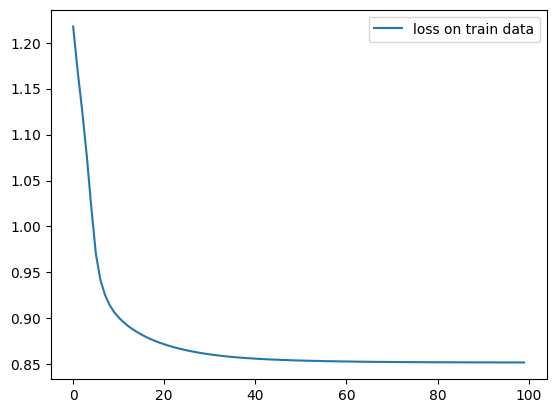

In [73]:
plt.plot(history.history['loss'])
plt.legend(['loss on train data', 'loss on validation data'])

In [74]:
dataset_size = 1000
X_origin = df.sample(n=dataset_size).copy(deep=True)
X_test = normalize_dataset(X_origin)
X_test

Processed DataFrame; normalized Dataframe created


,duration,packet_loss,mos,jitter,caller_id,organization_id,e164_from_caller_id,e164_to_caller_id,start_time,data_center,carrier_id,label,origination,destination,from_country,to_country
27768,-0.430612,-0.042932,0.514844,-0.473642,c70abbca-1a58-11ed-83fd-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,525500000001.0,8000000001.0,2022-08-12 16:06:51 UTC,NaN,1.0,NaN,MX,001,Mexico,Invalid
187853,0.760429,-0.042932,0.514844,-0.398015,b0384d12-17a7-11ed-a317-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,61200001644.0,611800000301.0,2022-08-09 05:54:10 UTC,NaN,79.0,NaN,AU,AU,Invalid,Invalid
279790,1.420082,-0.042932,0.514844,-0.334992,6e19b61c-1e89-11ed-b7a1-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,525500000001.0,528000000127.0,2022-08-18 00:05:12 UTC,NaN,112.0,NaN,MX,MX,Mexico,Mexico
46906,0.487239,-0.042932,0.514844,-0.322387,edab59f0-2251-11ed-a997-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,966120000032.0,9668000000060.0,2022-08-22 19:37:59 UTC,NaN,1.0,NaN,SA,SA,Saudi Arabia,Saudi Arabia
230240,0.125762,-0.042932,0.514844,-0.334992,a0d21094-1dc2-11ed-ac93-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,529610000003.0,8000000061.0,2022-08-17 00:22:07 UTC,NaN,99.0,NaN,NaN,001,Mexico,Invalid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194750,-0.378972,0.065564,0.514844,-0.347596,50a9fb44-1d0a-11ed-bba3-42010a4d3f9b,de40ac52-6733-11ec-beb9-ea31e1a86aa2,84900000372.0,842800000006.0,2022-08-16 02:22:45 UTC,NaN,85.0,NaN,DO,VN,Vietnam,Vietnam
77792,-0.292351,-0.042932,0.268419,0.219609,8f3c19dc-1292-11ed-96a2-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,527330000033.0,8000000021.0,2022-08-02 18:40:19 UTC,NaN,29.0,NaN,MX,001,Mexico,Invalid
136599,-0.387301,-0.042932,0.514844,-0.435828,ccc20ef8-1f83-11ed-9e12-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,61700000828.0,611800000307.0,2022-08-19 05:57:25 UTC,NaN,63.0,NaN,AU,AU,Invalid,Invalid
50708,-0.523896,-0.042932,0.514844,-0.473642,79038396-2389-11ed-bbfc-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,490000025375.0,490000016196.0,2022-08-24 08:48:06 UTC,NaN,4.0,NaN,DE,DE,Germany,Germany


In [75]:
x_test_recon = autoencoder.predict(X_test[numeric_cols])

# the reconstruction score is the mean of the reconstruction errors (relatively high scores are anomalous)
reconstruction_scores = np.mean((X_test[numeric_cols] - x_test_recon)**2, axis=1)

32/32 [==============================] - 0s 1ms/step


In [77]:
anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores})
anomaly_data

,recon_score
27768,0.518914
187853,0.089399
279790,0.117349
46906,0.101639
230240,0.098563
...,...
194750,0.190423
77792,0.042949
136599,0.482643
50708,0.581680


Threshold: 8.484232825707405
[134 197 222 226 886]


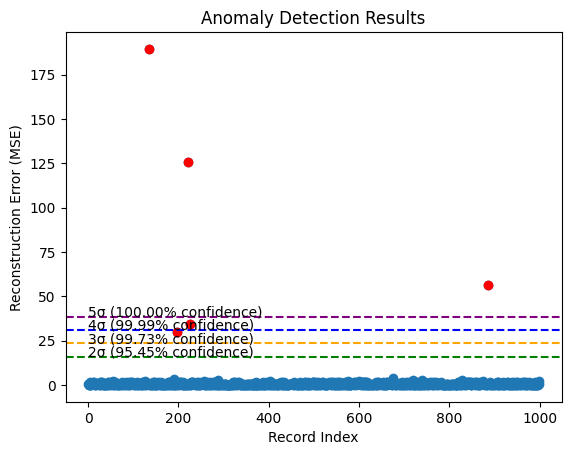

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf

# calculate mean and standard deviation
mse = np.mean(np.square(X_test[numeric_cols] - x_test_recon), axis=1)
threshold = np.mean(mse) + 1 * np.std(mse)
print(f"Threshold: {threshold}")
anomalies = np.where(mse > threshold)[0]

print(anomalies)
#print(mse.iloc[265])

mean_mse = np.mean(mse)
std_mse = np.std(mse)
# define thresholds based on number of standard deviations away from the mean
threshold_2std = mean_mse + 2 * std_mse
threshold_3std = mean_mse + 3 * std_mse
threshold_4std = mean_mse + 4 * std_mse
threshold_5std = mean_mse + 5 * std_mse
confidences = [100*erf(i/np.sqrt(2)) for i in range(2, 6)]
# create a scatter plot of the reconstruction error vs sample index
plt.scatter(range(len(mse)), mse)
# highlight the anomalies
plt.scatter(anomalies, mse.iloc[anomalies], color='red') #anomaly within anomalies (intended behavior?)
# add threshold lines
plt.axhline(y=threshold_2std, color='green', linestyle='--', label='2 std')
plt.text(0.02, threshold_2std + 0.2, f"2σ ({confidences[0]:.2f}% confidence)")
plt.axhline(y=threshold_3std, color='orange', linestyle='--', label='3 std')
plt.text(0.02, threshold_3std + 0.2, f"3σ ({confidences[1]:.2f}% confidence)")
plt.axhline(y=threshold_4std, color='blue', linestyle='--', label='4 std')
plt.text(0.02, threshold_4std + 0.2, f"4σ ({confidences[2]:.2f}% confidence)")
plt.axhline(y=threshold_5std, color='purple', linestyle='--', label='5 std')
plt.text(0.02, threshold_5std + 0.2, f"5σ ({confidences[3]:.2f}% confidence)")
# add labels and title
plt.xlabel('Record Index')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Anomaly Detection Results')
# display the plot
plt.show()

In [95]:
anomalies_df = X_origin.iloc[anomalies] #detected as anomaly
anomalies_df

,caller_id,organization_id,e164_from_caller_id,e164_to_caller_id,start_time,duration,data_center,carrier_id,packet_loss,mos,jitter,label,origination,destination,from_country,to_country,is_anomaly
202503,5c16e596-28e5-11ed-9dbe-42010a4d3f9c,cd3a8a0b-720f-11ec-8136-3289d3520e1d,16030000031.0,918071000001.0,2022-08-31 04:28:27 UTC,38,US,93.0,23.932,4.5,16,NaN,US,IN,Invalid,India,True
42283,39312fe6-12b5-11ed-a7ef-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,61200001643.0,611800000296.0,2022-08-02 22:48:27 UTC,1313,NaN,1.0,0.073,4.5,969,NaN,AU,AU,Invalid,Invalid,True
263174,7b2cee74-256d-11ed-b460-42010a4d3f9c,d03bfa4a-840b-11ec-8824-8aab77684a0e,16260001161.0,18550000026.0,2022-08-26 18:32:46 UTC,14400,NaN,101.0,0.000,4.5,2,NaN,US,US,Invalid,Invalid,True
61755,0206fc62-2241-11ed-9675-42010a4d3f9c,e9687c3b-db3c-11ec-ab89-6e26f4e96741,15740000403.0,12890000457.0,2022-08-22 17:36:52 UTC,64,NaN,8.0,0.000,4.4,1045,NaN,US,CA,Invalid,Invalid,True
45427,a0cb800c-1e22-11ed-b7a1-42010a4d3f9b,cd3a8a0b-720f-11ec-8136-3289d3520e1d,16030000074.0,918071000007.0,2022-08-17 11:49:19 UTC,12,NaN,1.0,11.489,4.5,752,NaN,US,IN,Invalid,India,True


In [93]:
non_anomalies_df = X_origin.drop(X_test.index[anomalies])
non_anomalies_df

,caller_id,organization_id,e164_from_caller_id,e164_to_caller_id,start_time,duration,data_center,carrier_id,packet_loss,mos,jitter,label,origination,destination,from_country,to_country,is_anomaly
27768,c70abbca-1a58-11ed-83fd-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,525500000001.0,8000000001.0,2022-08-12 16:06:51 UTC,79,NaN,1.0,0.000,4.5,1,NaN,MX,001,Mexico,Invalid,False
187853,b0384d12-17a7-11ed-a317-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,61200001644.0,611800000301.0,2022-08-09 05:54:10 UTC,794,NaN,79.0,0.000,4.5,7,NaN,AU,AU,Invalid,Invalid,False
279790,6e19b61c-1e89-11ed-b7a1-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,525500000001.0,528000000127.0,2022-08-18 00:05:12 UTC,1190,NaN,112.0,0.000,4.5,12,NaN,MX,MX,Mexico,Mexico,False
46906,edab59f0-2251-11ed-a997-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,966120000032.0,9668000000060.0,2022-08-22 19:37:59 UTC,630,NaN,1.0,0.000,4.5,13,NaN,SA,SA,Saudi Arabia,Saudi Arabia,False
230240,a0d21094-1dc2-11ed-ac93-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,529610000003.0,8000000061.0,2022-08-17 00:22:07 UTC,413,NaN,99.0,0.000,4.5,12,NaN,NaN,001,Mexico,Invalid,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194750,50a9fb44-1d0a-11ed-bba3-42010a4d3f9b,de40ac52-6733-11ec-beb9-ea31e1a86aa2,84900000372.0,842800000006.0,2022-08-16 02:22:45 UTC,110,NaN,85.0,0.091,4.5,11,NaN,DO,VN,Vietnam,Vietnam,False
77792,8f3c19dc-1292-11ed-96a2-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,527330000033.0,8000000021.0,2022-08-02 18:40:19 UTC,162,NaN,29.0,0.000,4.1,56,NaN,MX,001,Mexico,Invalid,False
136599,ccc20ef8-1f83-11ed-9e12-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,61700000828.0,611800000307.0,2022-08-19 05:57:25 UTC,105,NaN,63.0,0.000,4.5,4,NaN,AU,AU,Invalid,Invalid,False
50708,79038396-2389-11ed-bbfc-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,490000025375.0,490000016196.0,2022-08-24 08:48:06 UTC,23,NaN,4.0,0.000,4.5,1,NaN,DE,DE,Germany,Germany,False


In [94]:
X_origin['is_anomaly'] = False
X_origin['is_anomaly'].iloc[anomalies] = True
X_origin

/var/tmp/ipykernel_41660/659026680.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_origin['is_anomaly'].iloc[anomalies] = True
/var/tmp/ipykernel_41660/659026680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,caller_id,organization_id,e164_from_caller_id,e164_to_caller_id,start_time,duration,data_center,carrier_id,packet_loss,mos,jitter,label,origination,destination,from_country,to_country,is_anomaly
27768,c70abbca-1a58-11ed-83fd-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,525500000001.0,8000000001.0,2022-08-12 16:06:51 UTC,79,NaN,1.0,0.000,4.5,1,NaN,MX,001,Mexico,Invalid,False
187853,b0384d12-17a7-11ed-a317-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,61200001644.0,611800000301.0,2022-08-09 05:54:10 UTC,794,NaN,79.0,0.000,4.5,7,NaN,AU,AU,Invalid,Invalid,False
279790,6e19b61c-1e89-11ed-b7a1-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,525500000001.0,528000000127.0,2022-08-18 00:05:12 UTC,1190,NaN,112.0,0.000,4.5,12,NaN,MX,MX,Mexico,Mexico,False
46906,edab59f0-2251-11ed-a997-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,966120000032.0,9668000000060.0,2022-08-22 19:37:59 UTC,630,NaN,1.0,0.000,4.5,13,NaN,SA,SA,Saudi Arabia,Saudi Arabia,False
230240,a0d21094-1dc2-11ed-ac93-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,529610000003.0,8000000061.0,2022-08-17 00:22:07 UTC,413,NaN,99.0,0.000,4.5,12,NaN,NaN,001,Mexico,Invalid,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194750,50a9fb44-1d0a-11ed-bba3-42010a4d3f9b,de40ac52-6733-11ec-beb9-ea31e1a86aa2,84900000372.0,842800000006.0,2022-08-16 02:22:45 UTC,110,NaN,85.0,0.091,4.5,11,NaN,DO,VN,Vietnam,Vietnam,False
77792,8f3c19dc-1292-11ed-96a2-42010a4d3f9c,ea5c85af-672a-11eb-ad3b-c2be13501a60,527330000033.0,8000000021.0,2022-08-02 18:40:19 UTC,162,NaN,29.0,0.000,4.1,56,NaN,MX,001,Mexico,Invalid,False
136599,ccc20ef8-1f83-11ed-9e12-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,61700000828.0,611800000307.0,2022-08-19 05:57:25 UTC,105,NaN,63.0,0.000,4.5,4,NaN,AU,AU,Invalid,Invalid,False
50708,79038396-2389-11ed-bbfc-42010a4d3f9b,ea5c85af-672a-11eb-ad3b-c2be13501a60,490000025375.0,490000016196.0,2022-08-24 08:48:06 UTC,23,NaN,4.0,0.000,4.5,1,NaN,DE,DE,Germany,Germany,False


In [96]:
autoencoder.save('avoxi_workshop_bucket/saved_model/autoencoder_v3')

INFO:tensorflow:Assets written to: avoxi_workshop_bucket/saved_model/autoencoder_v3/assets


INFO:tensorflow:Assets written to: avoxi_workshop_bucket/saved_model/autoencoder_v3/assets


In [97]:
from google.cloud import bigquery

def insert_dataframe_as_table(project_id, dataset_id, table_id, dataframe):
    """
    Inserts a pandas DataFrame into a BigQuery table.

    Args:
        project_id (str): The Google Cloud project ID.
        dataset_id (str): The BigQuery dataset ID.
        table_id (str): The BigQuery table ID.
        dataframe (pandas.DataFrame): The DataFrame to insert.
    """

    client = bigquery.Client(project=project_id)

    # Determine schema from DataFrame if not explicitly provided
    job_config = bigquery.LoadJobConfig(
        autodetect=True, # Autodetect schema from DataFrame
        source_format=bigquery.SourceFormat.PARQUET,
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE # Overwrite existing table if it exists. 
    )

    # Load data from DataFrame
    job = client.load_table_from_dataframe(
        dataframe, f"{project_id}.{dataset_id}.{table_id}", job_config=job_config
    )

    job.result()  # Wait for the job to complete
    print(f"Loaded {job.output_rows} rows into {dataset_id}:{table_id}")

# Example Usage (replace with your actual data)
project_id = "gurkomal-playground"
dataset_id = "avoxi_workshop"
table_id = "local_autoencoder_labelled_prediction"
dataframe = X_origin

insert_dataframe_as_table(project_id, dataset_id, table_id, dataframe)

Loaded 1000 rows into avoxi_workshop:local_autoencoder_labelled_prediction
